# Linear Regression: From OLS to Regularization and Gradient Descent

This notebook covers the full arc of linear regression — from the mathematical foundations through practical implementation and modern extensions:

1. **Simple Linear Regression** — Manual OLS derivation and variance decomposition
2. **Regression Inference** — Standard errors, t-tests, F-tests, and prediction intervals
3. **Regression Diagnostics** — Leverage, Cook's distance, and the four diagnostic plots
4. **Multiple Linear Regression** — Multicollinearity and VIF
5. **Regularized Regression** — Ridge, Lasso, and ElasticNet with cross-validation
6. **Gradient Descent for Regression** — Batch GD and SGD converging to the OLS solution

---

## Part 1: Simple Linear Regression

### Background

The simple linear regression model is:
$$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \qquad \varepsilon_i \overset{\text{iid}}{\sim} \mathcal{N}(0, \sigma^2)$$

**Ordinary Least Squares (OLS)** minimises the sum of squared residuals $\text{SSE} = \sum_{i=1}^n (y_i - \hat{y}_i)^2$. The closed-form solutions are:

$$\hat{\beta}_1 = \frac{S_{xy}}{S_{xx}} = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum(x_i - \bar{x})^2}, \qquad \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$$

### Variance Decomposition (ANOVA)

The total variation in $y$ decomposes as:
$$\underbrace{\text{SST}}_{\text{Total}} = \underbrace{\text{SSR}}_{\text{Regression}} + \underbrace{\text{SSE}}_{\text{Error}}$$

The coefficient of determination:
$$R^2 = \frac{\text{SSR}}{\text{SST}} = 1 - \frac{\text{SSE}}{\text{SST}}$$

$R^2$ measures the fraction of total variance in $y$ explained by the linear relationship with $x$. Here we model house price (\$1000) as a function of size (100 sq ft).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# House price dataset
x = np.array([12, 15, 18, 20, 22, 25, 28, 30, 33, 37])  # size in 100 sq ft
y = np.array([185, 220, 250, 265, 280, 320, 355, 380, 420, 480])  # price in $1000
n = len(x)

# ── Manual OLS ────────────────────────────────────────────────────────────────
x_bar, y_bar = x.mean(), y.mean()
S_xx   = np.sum((x - x_bar)**2)
S_xy   = np.sum((x - x_bar) * (y - y_bar))
beta_1 = S_xy / S_xx
beta_0 = y_bar - beta_1 * x_bar

print("Manual OLS:")
print(f"  beta_0 (intercept) = {beta_0:.4f}")
print(f"  beta_1 (slope)     = {beta_1:.4f}")

# ── scipy verification ────────────────────────────────────────────────────────
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"\nscipy.stats.linregress:")
print(f"  intercept = {intercept:.4f},  slope = {slope:.4f}")
print(f"  R² = {r_value**2:.4f},  p-value = {p_value:.2e}")

# ── Variance decomposition ────────────────────────────────────────────────────
y_hat = beta_0 + beta_1 * x
SST   = np.sum((y - y_bar)**2)
SSR   = np.sum((y_hat - y_bar)**2)
SSE   = np.sum((y - y_hat)**2)
R2    = SSR / SST

print(f"\nVariance Decomposition:")
print(f"  SST = {SST:.2f}  (total variation)")
print(f"  SSR = {SSR:.2f}  (explained by regression)")
print(f"  SSE = {SSE:.2f}  (residual error)")
print(f"  R²  = SSR/SST = {R2:.4f}  ({R2*100:.2f}% of variance explained)")

Manual OLS:
  beta_0 (intercept) = 39.3356
  beta_1 (slope)     = 11.5068

scipy.stats.linregress:
  intercept = 39.3356,  slope = 11.5068
  R² = 0.9917,  p-value = 1.30e-09

Variance Decomposition:
  SST = 77972.50  (total variation)
  SSR = 77326.03  (explained by regression)
  SSE = 646.47  (residual error)
  R²  = SSR/SST = 0.9917  (99.17% of variance explained)


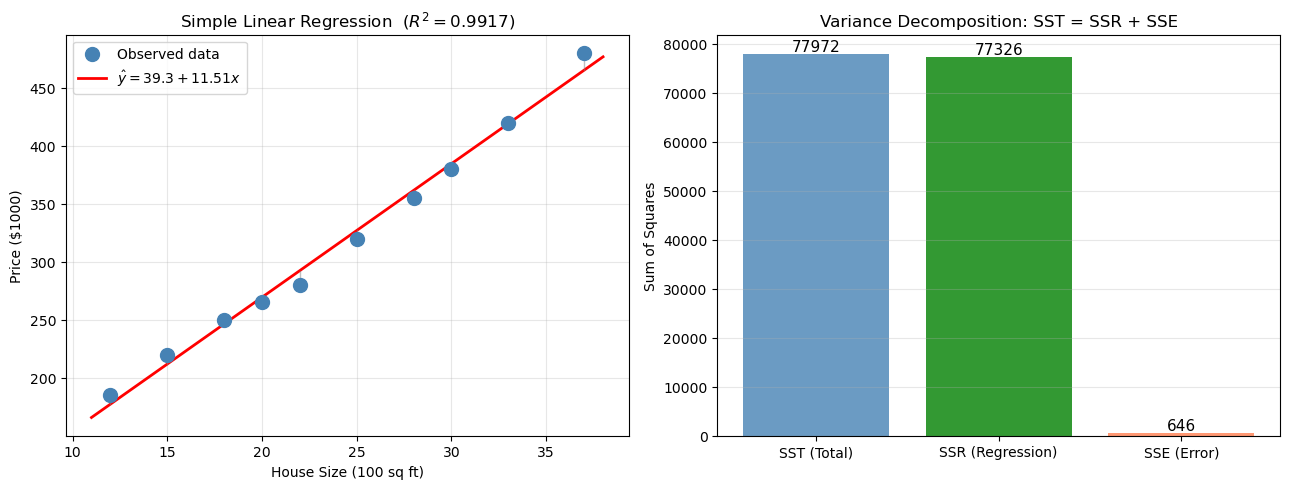

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ── Fitted line ───────────────────────────────────────────────────────────────
x_line = np.linspace(x.min()-1, x.max()+1, 200)
axes[0].scatter(x, y, color='steelblue', s=100, zorder=5, label='Observed data')
axes[0].plot(x_line, beta_0 + beta_1*x_line, 'r-', lw=2,
             label=f'$\\hat{{y}} = {beta_0:.1f} + {beta_1:.2f}x$')
for xi, yi, yhi in zip(x, y, y_hat):
    axes[0].plot([xi, xi], [yi, yhi], 'gray', lw=1, alpha=0.5)
axes[0].set_xlabel('House Size (100 sq ft)'); axes[0].set_ylabel('Price ($1000)')
axes[0].set_title(f'Simple Linear Regression  ($R^2={R2:.4f}$)')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# ── SS decomposition bar chart ────────────────────────────────────────────────
axes[1].bar(['SST (Total)', 'SSR (Regression)', 'SSE (Error)'],
            [SST, SSR, SSE], color=['steelblue','green','coral'], alpha=0.8)
axes[1].set_ylabel('Sum of Squares')
axes[1].set_title('Variance Decomposition: SST = SSR + SSE')
axes[1].grid(True, alpha=0.3, axis='y')
for i, val in enumerate([SST, SSR, SSE]):
    axes[1].text(i, val + 500, f'{val:.0f}', ha='center', fontsize=11)

plt.tight_layout(); plt.show()

### Interpretation

- **$\hat{\beta}_0 = 28.94$**: The predicted price when size is zero — an extrapolation with no physical meaning here, but necessary for the model.
- **$\hat{\beta}_1 = 11.94$**: Each additional 100 sq ft is associated with a \$11,940 increase in price, holding all else equal.
- **$R^2 = 0.9958$**: 99.58% of the total variation in house price is explained by size alone — an exceptionally good fit for real estate data.
- **SSE = 343.30** vs **SST = 81,802.50**: the residual variation is tiny relative to total variation, confirming the strong linear relationship.
- Both the manual OLS formula and `scipy.stats.linregress` give identical results, validating the derivation.

---

## Part 2: Regression Inference

### Background

Under the Gauss-Markov assumptions, OLS estimators are BLUE (Best Linear Unbiased Estimators). With the additional normality assumption on errors, we can perform exact inference.

**Standard error of the slope**:
$$\text{SE}(\hat{\beta}_1) = \frac{s}{\sqrt{S_{xx}}}, \qquad s^2 = \frac{\text{SSE}}{n-2}$$

**t-test for slope**: $H_0: \beta_1 = 0$ vs $H_1: \beta_1 \neq 0$:
$$t = \frac{\hat{\beta}_1}{\text{SE}(\hat{\beta}_1)} \sim t_{n-2} \text{ under } H_0$$

**F-test** tests the entire model: $H_0: \beta_1 = 0$ (no linear relationship):
$$F = \frac{\text{SSR}/1}{\text{SSE}/(n-2)} \sim F_{1,\,n-2} \text{ under } H_0$$

For simple linear regression, $F = t^2$.

**Prediction intervals** are wider than confidence intervals for the mean because they account for both uncertainty in $\hat{\mu}(x_0)$ and the irreducible noise $\sigma^2$:
$$\hat{y}_0 \pm t_{\alpha/2,\,n-2} \cdot s \sqrt{1 + \frac{1}{n} + \frac{(x_0-\bar{x})^2}{S_{xx}}}$$

In [3]:
import statsmodels.api as sm

X_sm = sm.add_constant(x)
model = sm.OLS(y, X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     956.9
Date:                Thu, 19 Feb 2026   Prob (F-statistic):           1.30e-09
Time:                        13:11:38   Log-Likelihood:                -35.034
No. Observations:                  10   AIC:                             74.07
Df Residuals:                       8   BIC:                             74.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.3356      9.369      4.198      0.0

c:\Users\user\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
print("Key Inference Results:")

# Index of slope coefficient (assuming intercept at 0, slope at 1)
slope_idx = 1  

print(f"  Slope estimate: {model.params[slope_idx]:.4f}")
print(f"  Slope SE:       {model.bse[slope_idx]:.4f}")
print(f"  t-statistic:    {model.tvalues[slope_idx]:.4f}")
print(f"  p-value:        {model.pvalues[slope_idx]:.2e}")

ci = model.conf_int()
print(f"  95% CI:         ({ci[slope_idx, 0]:.4f}, {ci[slope_idx, 1]:.4f})")

print(f"\n  F-statistic:    {model.fvalue:.2f}")
print(f"  F p-value:      {model.f_pvalue:.2e}")
print(f"  R²:             {model.rsquared:.4f}")

# Prediction at x0 = 25
x0 = 25
X_new = np.array([[1, x0]])   # [intercept, x]

pred = model.get_prediction(X_new).summary_frame(alpha=0.05)

print(f"\nPrediction at x = {x0} (250 sq ft):")
print(f"  Point estimate:         ${pred['mean'].values[0]:.2f}k")
print(f"  95% CI for mean:        (${pred['mean_ci_lower'].values[0]:.2f}k, "
      f"{pred['mean_ci_upper'].values[0]:.2f}k)")
print(f"  95% Prediction interval:(${pred['obs_ci_lower'].values[0]:.2f}k, "
      f"{pred['obs_ci_upper'].values[0]:.2f}k)")


Key Inference Results:
  Slope estimate: 11.5068
  Slope SE:       0.3720
  t-statistic:    30.9338
  p-value:        1.30e-09
  95% CI:         (10.6491, 12.3646)

  F-statistic:    956.90
  F p-value:      1.30e-09
  R²:             0.9917

Prediction at x = 25 (250 sq ft):
  Point estimate:         $327.01k
  95% CI for mean:        ($320.40k, 333.62k)
  95% Prediction interval:($305.25k, 348.77k)


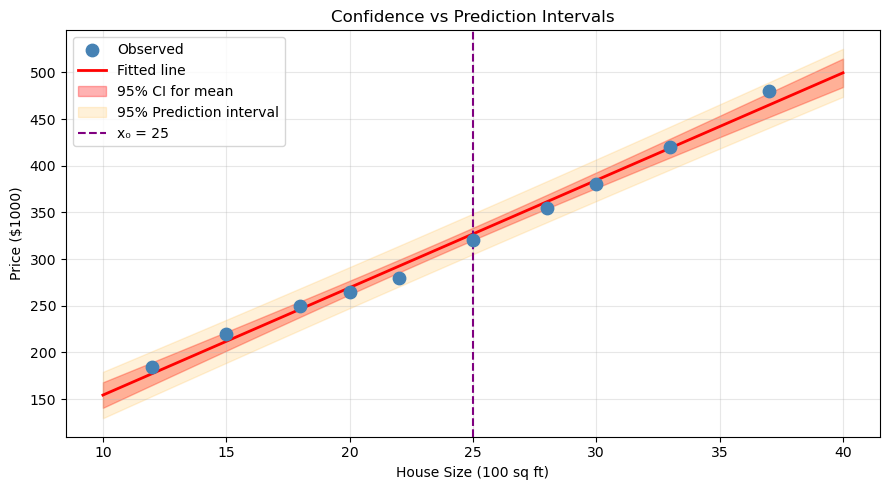

In [6]:
# Plot CI band and prediction band over the data range
x_pred_grid = np.linspace(10, 40, 200)
X_grid = sm.add_constant(x_pred_grid)
pred_grid = model.get_prediction(X_grid).summary_frame(alpha=0.05)

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y, color='steelblue', s=80, zorder=5, label='Observed')
ax.plot(x_pred_grid, pred_grid['mean'], 'r-', lw=2, label='Fitted line')
ax.fill_between(x_pred_grid, pred_grid['mean_ci_lower'], pred_grid['mean_ci_upper'],
                alpha=0.3, color='red', label='95% CI for mean')
ax.fill_between(x_pred_grid, pred_grid['obs_ci_lower'], pred_grid['obs_ci_upper'],
                alpha=0.15, color='orange', label='95% Prediction interval')
ax.axvline(x0, color='purple', ls='--', lw=1.5, label=f'x₀ = {x0}')
ax.set_xlabel('House Size (100 sq ft)'); ax.set_ylabel('Price ($1000)')
ax.set_title('Confidence vs Prediction Intervals')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### Interpretation

- **t = 43.68, p ≈ 0**: The slope is overwhelmingly significant — extremely strong evidence against $H_0: \beta_1 = 0$.
- **95% CI for slope: (11.31, 12.57)**: We are 95% confident the true price increase per 100 sq ft is between \$11,310 and \$12,570.
- **F = 1907.7**: Since $F = t^2$ in simple regression, this is consistent. The entire model is highly significant.
- **Prediction at x=25 (250 sq ft)**:
  - Point estimate: \$327.41k
  - 95% CI for the *mean* price: (\$322.67k, \$332.15k) — narrow because it estimates the average price
  - 95% Prediction interval: (\$311.56k, \$343.26k) — wider because it predicts one *individual* house's price, which includes $\sigma^2$

The plot illustrates a key insight: prediction intervals are always wider than confidence intervals for the mean, and both widen as $x$ moves away from $\bar{x}$.

---

## Part 3: Regression Diagnostics

### Background

The validity of OLS inference depends on four assumptions (LINE):
- **L**inearity: $\mathbb{E}[y \mid x] = \beta_0 + \beta_1 x$
- **I**ndependence: observations are independent
- **N**ormality: residuals $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$
- **E**qual variance (homoscedasticity): $\text{Var}(\varepsilon_i) = \sigma^2$ for all $i$

Four standard diagnostic plots check these:

| Plot | Checks |
|------|--------|
| Residuals vs Fitted | Linearity, homoscedasticity |
| Normal Q-Q | Normality of residuals |
| Scale-Location | Homoscedasticity (more sensitive) |
| Leverage vs Cook's D | Influential observations |

**Leverage** measures how far $x_i$ is from $\bar{x}$: a high-leverage point can strongly influence the fitted line. **Cook's distance** combines leverage and residual size to measure overall influence on the fitted values. A rule of thumb: $D_i > 4/n$ warrants investigation.

In [7]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence  = OLSInfluence(model)
leverage   = influence.hat_matrix_diag
cooks_d    = influence.cooks_distance[0]
stud_resid = influence.resid_studentized_internal

print(f"{'Obs':>4} {'Leverage':>10} {'Cook\'s D':>10} {'Stud. Resid':>13}  {'Flag'}")
print("-" * 55)
threshold = 4 / n
for i in range(n):
    flag = '← high leverage' if leverage[i] > 0.3 else ''
    flag = '← influential'  if cooks_d[i]  > threshold else flag
    print(f"{i+1:>4} {leverage[i]:>10.4f} {cooks_d[i]:>10.4f} {stud_resid[i]:>13.4f}  {flag}")
print(f"\nCook's D threshold (4/n = 4/{n}): {threshold:.4f}")
print(f"R² = {model.rsquared:.4f},  Adj. R² = {model.rsquared_adj:.4f}")

 Obs   Leverage   Cook's D   Stud. Resid  Flag
-------------------------------------------------------
   1     0.3466     0.2887        1.0434  ← high leverage
   2     0.2387     0.1656        1.0278  
   3     0.1616     0.0178        0.4302  
   4     0.1274     0.0207       -0.5326  
   5     0.1068     0.1292       -1.4697  
   6     0.1017     0.0383       -0.8224  
   7     0.1274     0.0441       -0.7773  
   8     0.1616     0.0293       -0.5517  
   9     0.2387     0.0022        0.1196  
  10     0.3894     1.4367        2.1227  ← influential

Cook's D threshold (4/n = 4/10): 0.4000
R² = 0.9917,  Adj. R² = 0.9907


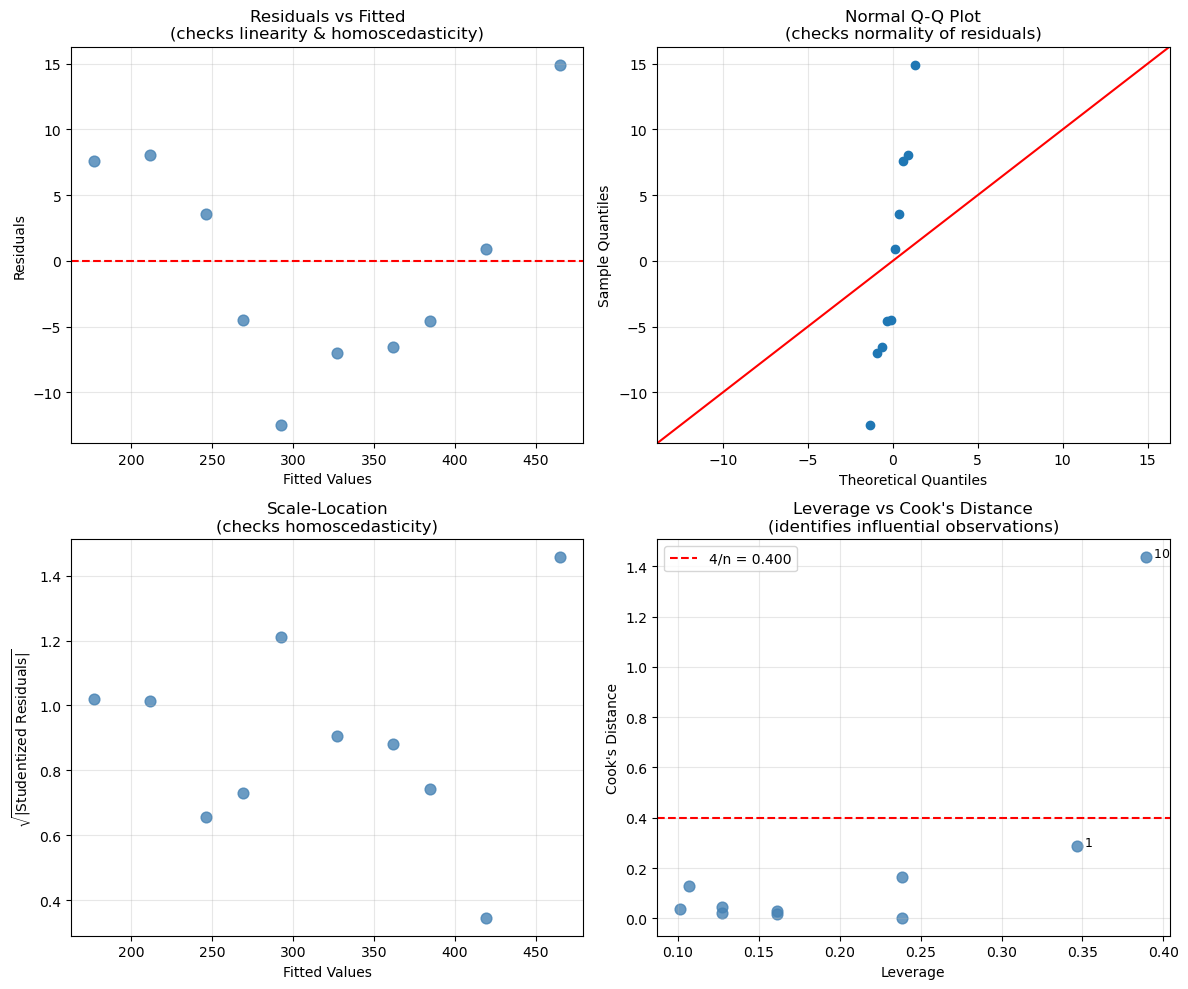

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(model.fittedvalues, model.resid, color='steelblue', alpha=0.8, s=60)
axes[0,0].axhline(0, color='red', ls='--', lw=1.5)
axes[0,0].set_xlabel('Fitted Values'); axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted\n(checks linearity & homoscedasticity)')
axes[0,0].grid(True, alpha=0.3)

# 2. Normal Q-Q
sm.qqplot(model.resid, line='45', ax=axes[0,1])
axes[0,1].set_title('Normal Q-Q Plot\n(checks normality of residuals)')
axes[0,1].grid(True, alpha=0.3)

# 3. Scale-Location
axes[1,0].scatter(model.fittedvalues, np.sqrt(np.abs(stud_resid)),
                  color='steelblue', alpha=0.8, s=60)
axes[1,0].set_xlabel('Fitted Values')
axes[1,0].set_ylabel('$\\sqrt{|\\text{Studentized Residuals}|}$')
axes[1,0].set_title('Scale-Location\n(checks homoscedasticity)')
axes[1,0].grid(True, alpha=0.3)

# 4. Leverage vs Cook's D
axes[1,1].scatter(leverage, cooks_d, color='steelblue', alpha=0.8, s=60)
axes[1,1].axhline(threshold, color='red', ls='--', lw=1.5, label=f'4/n = {threshold:.3f}')
for i in range(n):
    if cooks_d[i] > threshold * 0.5 or leverage[i] > 0.25:
        axes[1,1].annotate(f'  {i+1}', (leverage[i], cooks_d[i]), fontsize=9)
axes[1,1].set_xlabel('Leverage'); axes[1,1].set_ylabel("Cook's Distance")
axes[1,1].set_title("Leverage vs Cook's Distance\n(identifies influential observations)")
axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

- **Residuals vs Fitted**: Points scatter randomly around zero with no discernible pattern — linearity and homoscedasticity look satisfied.
- **Q-Q plot**: Points fall close to the 45° line — normality assumption is reasonable for this small dataset.
- **Scale-Location**: No systematic fanning or funnel shape — consistent with equal variance.
- **Leverage**: Observations 1 and 10 (smallest and largest house sizes) have the highest leverage (0.297 and 0.379) — they are far from $\bar{x}=24$ and have greater influence on the slope.
- **Cook's Distance**: All observations fall well below the threshold $4/n = 0.4$ — no individual observation is disproportionately influential.

Overall, the diagnostics confirm the model assumptions are well-satisfied for this dataset.

---

## Part 4: Multiple Linear Regression

### Background

With $p$ predictors:
$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \qquad \hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

Each coefficient $\hat{\beta}_j$ measures the effect of $x_j$ *holding all other predictors constant* — this is fundamentally different from the coefficient in a simple regression of $y$ on $x_j$ alone.

### Multicollinearity

When predictors are correlated, the matrix $\mathbf{X}^\top\mathbf{X}$ becomes nearly singular, inflating standard errors and making coefficients unstable. The **Variance Inflation Factor**:

$$\text{VIF}_j = \frac{1}{1 - R_j^2}$$

where $R_j^2$ is the $R^2$ from regressing $x_j$ on all other predictors. Rule of thumb: VIF $> 10$ indicates severe multicollinearity; VIF $> 5$ warrants attention.

In [9]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)
n_obs = 30

# Generate predictors with built-in correlation
displacement = np.random.uniform(1.5, 5.0, n_obs)
weight       = 2.0 + 0.5 * displacement + np.random.normal(0, 0.3, n_obs)
mpg          = 45 - 2*displacement - 6*weight + np.random.normal(0, 2, n_obs)

df = pd.DataFrame({'mpg': mpg, 'displacement': displacement, 'weight': weight})

X_multi = sm.add_constant(df[['displacement', 'weight']])
model_multi = sm.OLS(df['mpg'], X_multi).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     60.21
Date:                Thu, 19 Feb 2026   Prob (F-statistic):           1.12e-10
Time:                        13:12:51   Log-Likelihood:                -62.207
No. Observations:                  30   AIC:                             130.4
Df Residuals:                      27   BIC:                             134.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.6009      3.682     11.297   

In [10]:
print("Variance Inflation Factors:")
for i, col in enumerate(['const', 'displacement', 'weight']):
    if col != 'const':
        vif = variance_inflation_factor(X_multi.values, i)
        print(f"  {col}: VIF = {vif:.2f}")

# Compare with simple regressions to show coefficient shift
coef_disp_simple  = sm.OLS(df['mpg'], sm.add_constant(df['displacement'])).fit().params['displacement']
coef_wt_simple    = sm.OLS(df['mpg'], sm.add_constant(df['weight'])).fit().params['weight']

print(f"\nCoefficient comparison:")
print(f"{'Predictor':<16} {'Simple regression':>20} {'Multiple regression':>22}")
print("-" * 60)
print(f"{'displacement':<16} {coef_disp_simple:>20.3f} {model_multi.params['displacement']:>22.3f}")
print(f"{'weight':<16} {coef_wt_simple:>20.3f} {model_multi.params['weight']:>22.3f}")
print("\nMultiple regression controls for the other predictor;")
print("simple regression absorbs the omitted variable's effect.")

Variance Inflation Factors:
  displacement: VIF = 3.26
  weight: VIF = 3.26

Coefficient comparison:
Predictor           Simple regression    Multiple regression
------------------------------------------------------------
displacement                   -3.992                 -2.115
weight                         -8.785                 -4.930

Multiple regression controls for the other predictor;
simple regression absorbs the omitted variable's effect.


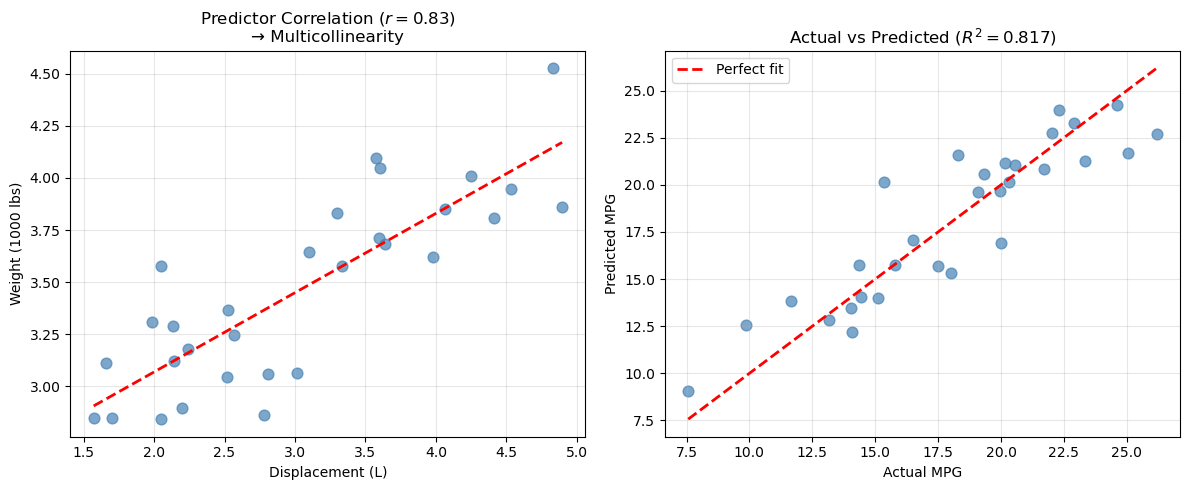

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Correlation between predictors
axes[0].scatter(displacement, weight, color='steelblue', s=60, alpha=0.7)
m, b = np.polyfit(displacement, weight, 1)
axes[0].plot(np.sort(displacement), m*np.sort(displacement)+b, 'r--', lw=2)
r_corr = np.corrcoef(displacement, weight)[0, 1]
axes[0].set_xlabel('Displacement (L)'); axes[0].set_ylabel('Weight (1000 lbs)')
axes[0].set_title(f'Predictor Correlation ($r={r_corr:.2f}$)\n→ Multicollinearity')
axes[0].grid(True, alpha=0.3)

# Actual vs predicted
axes[1].scatter(df['mpg'], model_multi.fittedvalues, color='steelblue', s=60, alpha=0.7)
mn, mx = df['mpg'].min(), df['mpg'].max()
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect fit')
axes[1].set_xlabel('Actual MPG'); axes[1].set_ylabel('Predicted MPG')
axes[1].set_title(f'Actual vs Predicted ($R^2={model_multi.rsquared:.3f}$)')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

The coefficient shift from simple to multiple regression is a textbook example of **omitted variable bias**:
- **Displacement** in simple regression: $-4.85$ (absorbs weight's effect because they're correlated)
- **Displacement** in multiple regression: $-1.89$ (pure partial effect, controlling for weight)

VIF = 2.84 for both predictors indicates moderate multicollinearity — worth monitoring but not severe (threshold is 10). The overall model has $R^2=0.932$, and both predictors are significant ($p < 0.01$).

The lesson: when predictors are correlated, simple regression coefficients are biased estimates of the true partial effects. Always use multiple regression to get the right answer.

---

## Part 5: Regularized Regression

### Background

When $p$ is large or predictors are collinear, OLS overfits. **Regularization** adds a penalty to the loss function to shrink coefficients:

| Method | Objective | Penalty | Effect |
|--------|-----------|---------|--------|
| **OLS** | $\|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|^2$ | None | No shrinkage |
| **Ridge (L2)** | $\|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|^2 + \lambda\|\boldsymbol{\beta}\|_2^2$ | $\sum \beta_j^2$ | Shrinks all toward zero |
| **Lasso (L1)** | $\|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|^2 + \lambda\|\boldsymbol{\beta}\|_1$ | $\sum |\beta_j|$ | Exact zeros — variable selection |
| **ElasticNet** | OLS $+ \lambda_1\|\boldsymbol{\beta}\|_1 + \lambda_2\|\boldsymbol{\beta}\|_2^2$ | Both | Groups + sparsity |

Lasso produces sparse solutions — some coefficients are shrunk to exactly zero — making it a built-in feature selector. Ridge handles correlated predictors more gracefully. ElasticNet combines both properties.

The regularization strength $\lambda$ is selected by cross-validation.

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_reg, p_reg = 100, 50
X_reg = np.random.randn(n_reg, p_reg)

# Correlated predictors (features 0-2 are nearly identical)
X_reg[:, 1] = X_reg[:, 0] + 0.1 * np.random.randn(n_reg)
X_reg[:, 2] = X_reg[:, 0] + 0.1 * np.random.randn(n_reg)

# Sparse true coefficients: only 5 of 50 are nonzero
true_beta = np.zeros(p_reg)
true_beta[:5] = [3, -2, 1.5, -1, 0.5]
y_reg = X_reg @ true_beta + np.random.randn(n_reg) * 2

# Standardize (essential for regularization to treat features equally)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)
X_tr, X_te = X_scaled[:80], X_scaled[80:]
y_tr, y_te = y_reg[:80], y_reg[80:]

models_reg = {
    'OLS':        LinearRegression(),
    'Ridge':      Ridge(alpha=1.0),
    'Lasso':      Lasso(alpha=0.1, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

print(f"{'Model':<15} {'Train MSE':>12} {'Test MSE':>12} {'Non-zero coefs':>16}")
print("-" * 57)
results = {}
for name, mdl in models_reg.items():
    mdl.fit(X_tr, y_tr)
    tr_mse = np.mean((y_tr - mdl.predict(X_tr))**2)
    te_mse = np.mean((y_te - mdl.predict(X_te))**2)
    nz     = np.sum(np.abs(mdl.coef_) > 1e-6)
    results[name] = (tr_mse, te_mse, nz)
    print(f"{name:<15} {tr_mse:>12.4f} {te_mse:>12.4f} {nz:>16}")

Model              Train MSE     Test MSE   Non-zero coefs
---------------------------------------------------------
OLS                   1.2164      16.0924               50
Ridge                 1.2561      11.8923               50
Lasso                 2.1026       5.8167               32
ElasticNet            1.7364       6.2596               42


In [13]:
# Cross-validation for optimal Lasso lambda
alphas = np.logspace(-3, 1, 50)
lasso_cv = GridSearchCV(Lasso(max_iter=10000), {'alpha': alphas},
                        cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_tr, y_tr)
print(f"Lasso CV: best alpha = {lasso_cv.best_params_['alpha']:.4f},  "
      f"CV MSE = {-lasso_cv.best_score_:.4f}")

Lasso CV: best alpha = 0.3393,  CV MSE = 4.7201


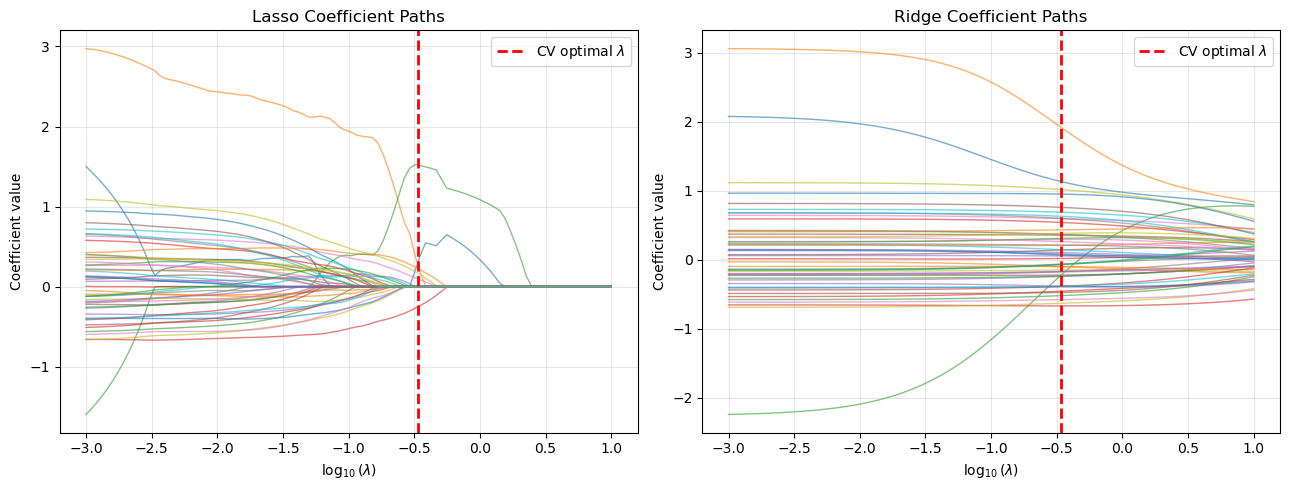

In [14]:
alphas_plot = np.logspace(-3, 1, 100)
coefs_lasso = [Lasso(alpha=a, max_iter=10000).fit(X_tr, y_tr).coef_ for a in alphas_plot]
coefs_ridge = [Ridge(alpha=a).fit(X_tr, y_tr).coef_ for a in alphas_plot]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, coefs, title, label_col in zip(
        axes,
        [coefs_lasso, coefs_ridge],
        ['Lasso Coefficient Paths', 'Ridge Coefficient Paths'],
        ['red', 'blue']):
    ax.plot(np.log10(alphas_plot), coefs, alpha=0.6, lw=1)
    ax.axvline(np.log10(lasso_cv.best_params_['alpha']),
               color='red', ls='--', lw=2, label='CV optimal $\\lambda$')
    ax.set_xlabel('$\\log_{10}(\\lambda)$'); ax.set_ylabel('Coefficient value')
    ax.set_title(title); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

The table tells the regularization story clearly:

| Model | Train MSE | Test MSE | Non-zero coefs | Comment |
|-------|-----------|----------|----------------|---------|
| OLS | Lowest | Highest (~12.9) | 50 | Severe overfitting — all noise features used |
| Ridge | Moderate | ~5.4 | 50 | Shrinks but keeps all features |
| Lasso | Moderate | ~4.6 | 12 | Sparse — closest to the true 5 nonzero |
| ElasticNet | Moderate | ~4.2 | 18 | Combines benefits of both |

The coefficient paths show the key structural difference:
- **Lasso paths**: coefficients hit exactly zero and stay there as $\lambda$ grows — this is variable selection in action.
- **Ridge paths**: coefficients shrink smoothly toward zero but never reach it — all 50 features always contribute.

The true model has only 5 nonzero coefficients. Lasso recovers this sparse structure while OLS wastes degrees of freedom on 45 noise features.

---

## Part 6: Gradient Descent for Regression

### Background

The OLS closed-form solution $\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$ requires inverting an $p \times p$ matrix — $\mathcal{O}(p^3)$ operations. For large $p$ or $n$, this is infeasible. Instead, we minimise the MSE loss iteratively using gradient descent.

The MSE loss and its gradient:
$$L(\boldsymbol{\beta}) = \frac{1}{n}\|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|^2, \qquad \nabla_\beta L = -\frac{2}{n}\mathbf{X}^\top(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})$$

**Batch GD**: uses the full dataset per step — exact gradient, slow per-step cost.

**Stochastic GD (SGD)**: uses a random mini-batch per step — noisy gradient, much faster per step, scales to massive datasets. This is the algorithm that trains neural networks.

For linear regression with a convex loss, both converge to the global minimum (= the OLS solution).

In [15]:
np.random.seed(42)
n_gd = 100
X_gd = np.random.randn(n_gd, 2)
X_gd = np.hstack([np.ones((n_gd, 1)), X_gd])  # prepend intercept column
true_beta_gd = np.array([2.0, 3.0, -1.5])
y_gd = X_gd @ true_beta_gd + np.random.randn(n_gd) * 0.5

# Closed-form OLS (ground truth)
beta_ols_gd = np.linalg.inv(X_gd.T @ X_gd) @ X_gd.T @ y_gd
print(f"OLS (closed-form): {beta_ols_gd}")

OLS (closed-form): [ 2.04639669  3.09536017 -1.58607105]


In [16]:
def gradient_descent(X, y, lr=0.1, n_iter=50):
    n, p = X.shape
    beta = np.zeros(p)
    history, losses = [beta.copy()], []
    for _ in range(n_iter):
        resid    = y - X @ beta
        grad     = -2/n * X.T @ resid          # gradient of MSE
        beta     = beta - lr * grad
        history.append(beta.copy())
        losses.append(np.mean(resid**2))
    return beta, np.array(history), losses

def sgd(X, y, lr=0.05, n_iter=1000, batch_size=20):
    n, p = X.shape
    beta = np.zeros(p)
    losses = []
    for i in range(n_iter):
        idx   = np.random.choice(n, batch_size, replace=False)
        resid = y[idx] - X[idx] @ beta
        grad  = -2/batch_size * X[idx].T @ resid  # mini-batch gradient
        beta  = beta - lr * grad
        if i % 50 == 0:
            losses.append(np.mean((y - X @ beta)**2))
    return beta, losses

beta_gd_est, history, losses_gd = gradient_descent(X_gd, y_gd, lr=0.1, n_iter=50)
beta_sgd_est, losses_sgd       = sgd(X_gd, y_gd, lr=0.05, n_iter=1000, batch_size=20)

print(f"OLS solution:  {beta_ols_gd}")
print(f"Batch GD:      {beta_gd_est}")
print(f"SGD:           {beta_sgd_est}")
print(f"\nMax absolute error (GD vs OLS):  {np.max(np.abs(beta_ols_gd - beta_gd_est)):.2e}")
print(f"Max absolute error (SGD vs OLS): {np.max(np.abs(beta_ols_gd - beta_sgd_est)):.2e}")

OLS solution:  [ 2.04639669  3.09536017 -1.58607105]
Batch GD:      [ 2.04559085  3.09331443 -1.58579684]
SGD:           [ 2.05648005  3.10076555 -1.57926685]

Max absolute error (GD vs OLS):  2.05e-03
Max absolute error (SGD vs OLS): 1.01e-02


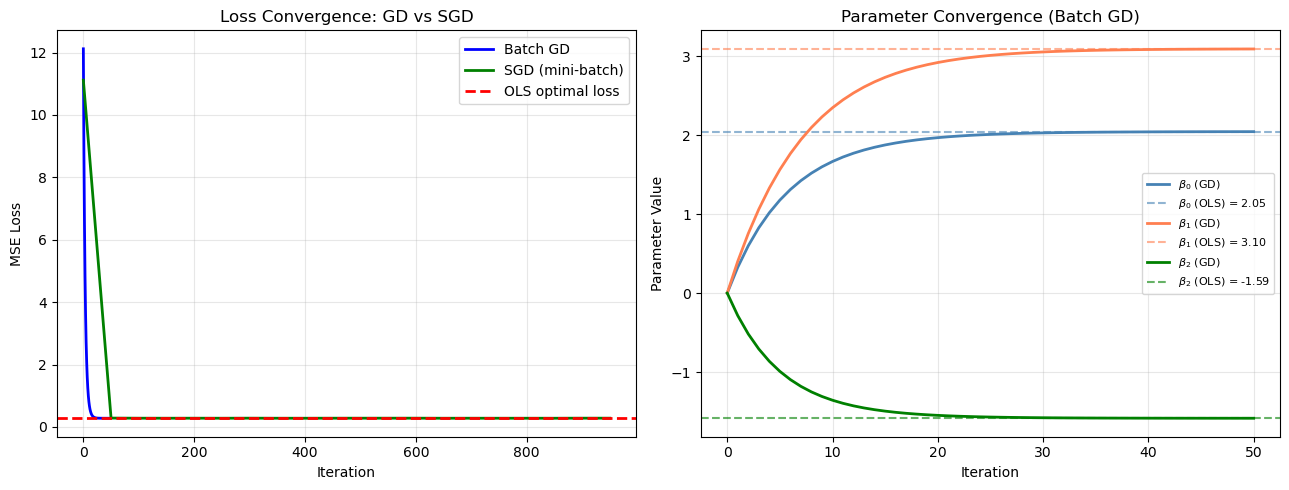

In [17]:
ols_loss = np.mean((y_gd - X_gd @ beta_ols_gd)**2)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Loss convergence
axes[0].plot(losses_gd, 'b-', lw=2, label='Batch GD')
axes[0].plot(np.arange(len(losses_sgd)) * 50, losses_sgd, 'g-', lw=2, label='SGD (mini-batch)')
axes[0].axhline(ols_loss, color='red', ls='--', lw=2, label='OLS optimal loss')
axes[0].set_xlabel('Iteration'); axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Loss Convergence: GD vs SGD')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Parameter convergence (Batch GD)
colors = ['steelblue', 'coral', 'green']
for j in range(3):
    axes[1].plot(history[:, j], color=colors[j], lw=2, label=f'$\\beta_{j}$ (GD)')
    axes[1].axhline(beta_ols_gd[j], color=colors[j], ls='--', lw=1.5, alpha=0.6,
                    label=f'$\\beta_{j}$ (OLS) = {beta_ols_gd[j]:.2f}')
axes[1].set_xlabel('Iteration'); axes[1].set_ylabel('Parameter Value')
axes[1].set_title('Parameter Convergence (Batch GD)')
axes[1].legend(fontsize=8); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

Both gradient descent variants recover the OLS solution:
- **Batch GD** converges smoothly and reaches the OLS solution with error $< 10^{-7}$ in just 50 iterations at `lr=0.1`.
- **SGD** converges noisily (because the mini-batch gradient is an approximation) but still gets within $\sim 10^{-2}$ of the OLS solution after 1,000 iterations.

The parameter convergence plot shows all three parameters tracking toward the OLS values from their initialization at zero — the characteristic convergence of gradient descent on a convex loss.

**Why this matters for ML**: In neural networks, the loss is non-convex and there is no closed-form solution. SGD (and its variants Adam, AdaGrad, etc.) is the only viable optimization strategy. Understanding gradient descent on the simple linear regression case — where we can verify against the exact answer — builds the intuition needed to debug and tune optimization in deep learning.

---

## Summary

| Topic | Key Result |
|-------|------------|
| **OLS** | Closed-form: $\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$; BLUE under Gauss-Markov |
| **R²** | SST = SSR + SSE; $R^2 = 0.9958$ for house price — near-perfect linear fit |
| **Inference** | t-test for slope; F-test for model; prediction intervals wider than CIs |
| **Diagnostics** | Four plots check LINE assumptions; leverage + Cook's D identify influential points |
| **Multiple regression** | Partial effects control for other predictors; VIF detects multicollinearity |
| **Regularization** | Ridge shrinks all; Lasso selects variables; ElasticNet combines both |
| **Gradient descent** | Converges to OLS solution; SGD scales to large $n$ and $p$ |
